In [181]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time
import seaborn as sb
from pylab import rcParams

# Define Functions

Make sure all antibiotic starting points are in the carrier (value 0) rather than reservoir shell (value 1)

In [182]:
def in_carrier(Ab,R,Size,ST):
    x = Ab[:,0]
    y = Ab[:,1]
    z = Ab[:,2]
    elute = Ab[:,4]
    for i in range(len(Ab)):
        while R[x[i],y[i],z[i]] != 0: 
            x[i],y[i] = np.random.randint(0,Size+2*ST,size = 2) # set new starting point until it is in the carrier
            z[i] = np.random.randint(0,Size+2)
    Ab[:,0] = x
    Ab[:,1] = y
    Ab[:,2] = z
    
    return Ab

When antibiotics move one step, make sure they move into carrier (value 0 or 3) rather than reservoir shell (value 1).  Label any eluted antibiotics (moved into exit (value of 3)) by replacing 0 (not eluted) with 1 (eluted) in final column (column 4) of antibiotic array. If antibiotic moved, cumulative number of steps (column 3 in antibiotic array) increases by one.

In [183]:
def move_once(Ab,Reservoir):
    # boolean mask to target non-eluted antibiotics
    b = Ab[:,4] == 0  
    b = b[:,np.newaxis]
    
    # pick random direction for antibiotic to move
    move_direction = np.random.randint(-1,2,size = [len(Ab),3]) 
    move = b*move_direction + Ab[:,0:3] # determine where the new location would be
    x = move[:,0]
    y = move[:,1]
    z = move[:,2]
    Material = Reservoir[x,y,z] # identify what is the material type of the location of the move
    
    # create Boolean masks to isolate antibiotics in different materials
    b_carrier = Material == 0
    b_exit = Material == 3
    b_carrier = b_carrier[:,np.newaxis]
    b_exit = b_exit[:,np.newaxis]
    
    # Update all antibiotics except ones that are already eluted or would move into reservoir material (value 1)
    Ab[:,0:3] += b*b_carrier*move_direction # non-eluted antibiotics move to carrier
    Ab[:,4:5] += 1*b_exit*b # update eluted column for antibiotics that eluted 
    
    # Update cumulative number of steps for non-eluted antibiotics
    Ab[:,3:4] += 1*b

    return Ab
        

Shift all exits (value 3) inward one time by replacing adjacent carrier (value 0) to simulate erosion 

In [184]:
def Surf_degrade(Reservoir):
    
    # determine difference between adjacent values in Reservoir array
    x = np.diff(Reservoir,axis=0)
    y = np.diff(Reservoir,axis=1)
    z = np.diff(Reservoir,axis=2)
    
    # determine indeces in Reservoir array where there is a carrier (value 0) next to an exit (value 3)
    # which has a difference of abs(3).  Since len(diff matrix) decreases by one, values of -3 need
    # to be shifted by one (but not for +3)
    i_x_pos = np.asarray(np.where(x==3))
    i_y_pos = np.asarray(np.where(y==3))
    i_z_pos = np.asarray(np.where(z==3))
    i_x_neg = np.asarray(np.where(x==-3))
    i_y_neg = np.asarray(np.where(y==-3))
    i_z_neg = np.asarray(np.where(z==-3))
    i_x_neg[0,:] += 1
    i_y_neg[1,:] += 1
    i_z_neg[2,:] += 1
    
    # Convert all carrier values adjacent to exit values into exit values themselves
    Reservoir[i_x_pos[0,:],i_x_pos[1,:],i_x_pos[2,:]] = 3
    Reservoir[i_y_pos[0,:],i_y_pos[1,:],i_y_pos[2,:]] = 3
    Reservoir[i_z_pos[0,:],i_z_pos[1,:],i_z_pos[2,:]] = 3
    Reservoir[i_x_neg[0,:],i_x_neg[1,:],i_x_neg[2,:]] = 3
    Reservoir[i_y_neg[0,:],i_y_neg[1,:],i_y_neg[2,:]] = 3
    Reservoir[i_z_neg[0,:],i_z_neg[1,:],i_z_neg[2,:]] = 3
        
    return Reservoir
    
    
    

Initialize reservoir

In [185]:
def init_Reservoir(Size,d,L,ST,s):
    X = ST+(Size-d)//2
    Z = 1+(Size-d)//2
    E = Size+2*ST
    
    # initialize Reservoir with carrier values (0)
    R = np.zeros([E,E,Size+2])

    # edges of Reservoir are converted into Reservoir shell (value 1)
    R[:,:,0] = 1
    R[:,:,-1] = 1
    R[0:ST,:,:] = 1
    R[0,X:X+d,Z:Z+d] = 3

    # Create shell surrounding channel
    R[1:L,X-s:X+d+s,Z-s:Z+d+s] = 1

    # Hollow out shell to create channel
    R[1:L,X:X+d,Z:Z+d] = 0

    # Flip to make channel on opposite side and concatenate into same array
    R2 = np.flip(R)
    R_trash,R2_split = np.split(R2,2,axis=0)
    R1_split,R_trash = np.split(R,2,axis=0)
    R12 = np.concatenate((R1_split,R2_split))

    # Transpose to make other two channels
    R34 = np.transpose(R12,axes=(1,0,2))

    # Combine into an array with all four channels
    Reservoir = R12 + R34
    Reservoir = np.where(Reservoir==2,1,Reservoir)
    
    return Reservoir

2D reservoir animation to confirm/visualize shape

In [383]:
%matplotlib notebook
def animate(i):
    Reservoir_slice = Reservoir[:,:,i]
    colors = plt.get_cmap('hot',4)
    p = plt.pcolormesh(Reservoir_slice, cmap=colors, vmin=0, vmax=3)

# View animation of reservoirs with different geometries    
Size = 90
d = 20
L = 27
ST = 9
s = 4
Reservoir = init_Reservoir(Size,d,L,ST,s)    
fig = plt.figure(figsize=(6,6))
plt.title('Animation - Aerial View of Reservoir')
plt.axis('off')
ani = animation.FuncAnimation(fig, animate, frames=Size+2, repeat=True, interval=3)

<IPython.core.display.Javascript object>

#### Interactive reservoir visualization
- Can be used to look at different channel lengths and diameters
- Can be used to look at different levels of surface erosion.
- Adjust the slider to look at different cross-sectional heights of the reservoir 3D matrix
- Colors:
    - light blue represents the fluid at the interface of the biodegradable cement where antibiotics can elute
    - light gray represents the biodegradable cement impregnated with antibiotics
    - black represents reservoir material

<IPython.core.display.Javascript object>


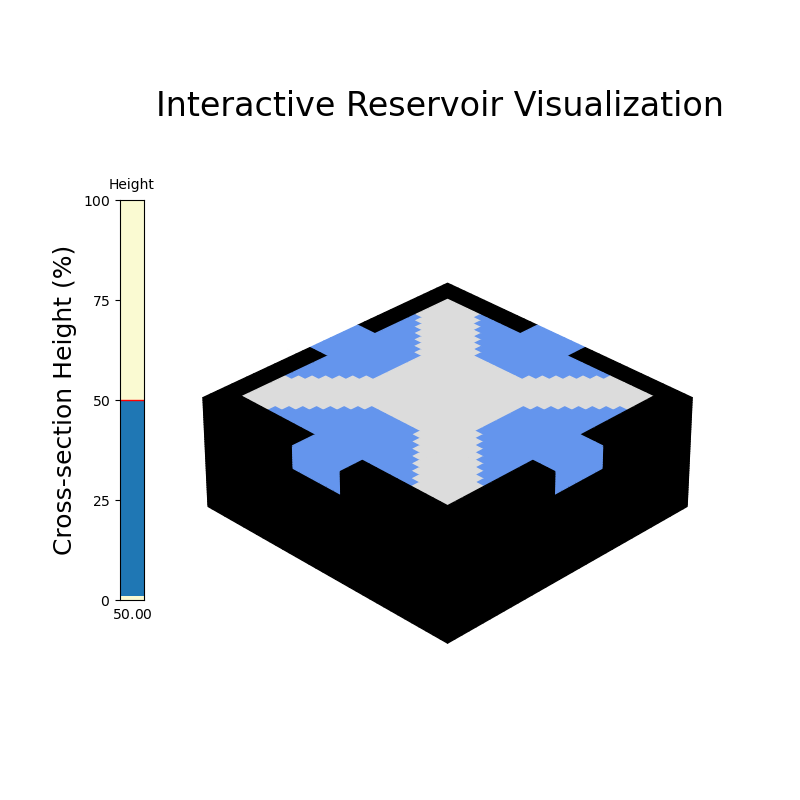

In [16]:
%matplotlib notebook
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.mplot3d import Axes3D

def make_colors(color_reference):
    color_grid = np.empty(color_reference.shape, dtype='U15')
    colors = ['cornflowerblue', 'black', 'gainsboro']
    for i in range(color_reference.shape[0]):
        for j in range(color_reference.shape[1]):
            if color_reference[i,j] == 0:
                color_grid[i,j] = colors[2]
            elif color_reference[i,j] == 1:
                color_grid[i,j] = colors[1]
            else:
                color_grid[i,j] = colors[0]
    return color_grid 

def Make_Faces(Z_per):
    Z_max = 92
    Z = np.int(np.round(Z_per*Z_max/100))
    # face 1
    xs = np.zeros(108)
    ys = np.arange(108)
    zs = np.arange(Z)
    Z1, X1 = np.meshgrid(zs, xs)
    Z1, Y1 = np.meshgrid(zs, ys)

    color_reference1 = Reservoir[0,:,:Z]
    color_grid1 = make_colors(color_reference1)

    # face 2
    X2 = Y1
    Y2 = X1
    Z2 = Z1
    color_reference2 = Reservoir[:,0,:Z]
    color_grid2 = make_colors(color_reference2)

    # face 3
    xs = np.arange(108)
    X3, Y3 = np.meshgrid(xs, xs)
    Z3 = np.ones((108,108))*(Z-1)

    color_reference3 = Reservoir[:,:,Z-1]
    color_grid3 = make_colors(color_reference3)
    
    return X1, Y1, Z1, color_grid1, X2, Y2, Z2, color_grid2, X3, Y3, Z3, color_grid3

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
plt.title('Interactive Reservoir Visualization', fontsize=24)
plt.subplots_adjust(left=0.2)
ax._axis3don = False
ax.set_xlim(0,107)
ax.set_ylim(0,107)
ax.set_zlim(0,91)
ax.view_init(30, 225)

Size = 90
d = 20
L = 9
ST = 9
s = 4
Reservoir = init_Reservoir(Size,d,L,ST,s)
for i in range(30):
    Reservoir = Surf_degrade(Reservoir)

Z_per = 46*(100/92)
X1, Y1, Z1, color_grid1, X2, Y2, Z2, color_grid2, X3, Y3, Z3, color_grid3 = Make_Faces(Z_per)

face1 = ax.plot_surface(X1, Y1, Z1, facecolors=color_grid1, shade=False)
face2 = ax.plot_surface(X2, Y2, Z2, facecolors=color_grid2, shade=False)
face3 = ax.plot_surface(X3, Y3, Z3, facecolors=color_grid3, shade=False)

axcolor = 'lightgoldenrodyellow'
ax_zper = plt.axes([0.15, 0.25, 0.03, 0.5], facecolor=axcolor)
s_zper = Slider(ax_zper, 'Height', 100/92, 100, valinit=Z_per, valstep=100/92, orientation='vertical')
ticks = np.arange(0, 101, 25)
ax_zper.set_yticks(ticks)
plt.xticks(fontsize=24)
ax_zper.set_ylabel('Cross-section Height (%)', fontsize=18)

def update(val):
    Z_per = s_zper.val
    X1, Y1, Z1, color_grid1, X2, Y2, Z2, color_grid2, X3, Y3, Z3, color_grid3 = Make_Faces(Z_per)
    
    ax.clear()
    ax.set_title('Interactive Reservoir Visualization', fontsize=24)
    ax._axis3don = False
    ax.set_xlim(0,107)
    ax.set_ylim(0,107)
    ax.set_zlim(0,91)
    ax.view_init(30, 225)
    
    ax.plot_surface(X1, Y1, Z1, facecolors=color_grid1, shade=False)
    ax.plot_surface(X2, Y2, Z2, facecolors=color_grid2, shade=False)
    ax.plot_surface(X3, Y3, Z3, facecolors=color_grid3, shade=False)
    
    fig.canvas.draw_idle()
    
s_zper.on_changed(update)
plt.savefig('Res_section_1.png')

Experimental data to determine model fit

In [186]:
def experimental_data(d):

    Time_points = [0, 1, 3, 5, 7, 9, 11, 13, 17, 21, 25, 30, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133]

    D10 = [0, 0.060795138, 0.096584449, 0.133186293, 0.241388423, 0.391103488, 0.527989929, 0.626451674, 0.837716864, 0.944730148, 0.976973656, 0.989835003, 0.995497585, 0.998507229, 1]
   
    D20 = [0, 0.073969292, 0.163110654, 0.247388037, 0.436725438, 0.536666196, 0.669093816, 0.778851393, 0.945666374, 0.955653333, 0.978879194, 0.990719446, 0.995826415, 0.998605805, 1]

    D30 = [0, 0.142059027, 0.272496873, 0.504647687, 0.618195315, 0.742125299, 0.832500225, 0.88752394, 0.940428934, 0.972805009, 0.987473713, 0.99355641, 0.996579991, 0.998567061, 1]
    
    D40 = [0, 0.265158807, 0.396009383, 0.583929352, 0.670921859, 0.799018552, 0.863118541, 0.915781361, 0.948631217, 0.978180579, 0.987811014, 0.992732907, 0.995796679, 0.998199172, 1]
        
    D60 = [0, 0.413042076, 0.62974838, 0.757889091, 0.885387169, 0.935587586, 0.96083164, 0.970709083, 0.979716678, 0.985126306, 0.98878719, 0.99196247, 0.994637784, 0.997645184, 1]
    
    if d == 10:
        Data = D10
    elif d == 20:
        Data = D20
    elif d == 30:
        Data = D30
    elif d == 40:
        Data = D40
    elif d == 60:
        Data = D60
    else:
        # this is for using diameters that were not experimentally tested
        # note that this will give an inaccurate performance metric so ignore it
        Data = D10
    
    Time_points = Time_points[0:len(Data)]
    
    return Data, Time_points
    
    


The experimental data looks at reservoirs with varying diameter.  This code will run the simulation on one condition

In [187]:
def Test_One_Diameter(n_ab, Size, d, s, L, ST, Diff, Surf):

    # initialize Reservoir
    Reservoir = init_Reservoir(Size,d,L,ST,s)

    # create array with 5 columns for x,y,z coordinate in Reservoir, cumulative number of steps traveled, and
    # whether or not the antibiotic has eluted (0 is no, and 1 is yes)
    Ab = np.zeros([n_ab,5],dtype=int)

    # initialize x,y,z coordinates and make sure these coordinates are in carrier (value 0 or 3) and not shell (value 1)
    Ab[:,0:2] = np.random.randint(0,Size+2*ST,size = [n_ab,2])
    Ab[:,2] = np.random.randint(0,Size+2,size = n_ab)
    Ab = in_carrier(Ab,Reservoir,Size,ST)

    # Establish time points, experimental cumulative release, and predicted cumulative release vectors
    Data, Time_points = experimental_data(d)
    Cum_release = np.zeros(len(Time_points))
    
    # Establish flag variable that increases by 1 after each time point is reached
    flag = 1
    T_pt = Time_points[flag]

    # Initialize time and the number of steps traveled 
    step = 0
    Time = 0

    # random walk for antibiotics until all have eluted
    while np.sum(Ab[:,4]) < n_ab:
        Ab = move_once(Ab,Reservoir)
        
        # Update time based on Diff (diffusion rate constant)
        dt = Diff
        Time += dt
        
        # Reservoir experiences surface erosion at constant intervals determined by Surf (surface erosion rate constant)
        if (Time//Surf) != ((Time-dt)//Surf):
            Reservoir = Surf_degrade(Reservoir)
            
        # Record cumulative release at specified time points
        if (Time//T_pt) != ((Time-dt)//T_pt):
            if flag < len(Time_points):
                Cum_release[flag] = np.sum(Ab[:,4]/n_ab) 
                flag += 1
            if flag < len(Time_points):
                T_pt = Time_points[flag]            
        step += 1
    
    # For time points past the max time of while loop, update the cumulative release of those time points as 100%
    b = np.array(Time) < np.array(Time_points)
    Cum_release = b*1 + Cum_release
    
    # calculate performance
    P = 0.5*np.sum(np.square(Data - Cum_release))
    
    return Time_points, Cum_release, Data, P

Similar to the previous function but will test all conditions to match experimental data

In [188]:
def Test_All_Diameters(n_ab, Size, d, s, L, ST, Diff, Surf):    
    
    # Initialize Performance vector
    Performance = np.zeros(len(d))

    # Perform antibiotic elution and measure performance for all conditions 
    for i in range(len(d)):
        Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, d[i], s, L, ST, Diff, Surf)
        Performance[i] = P
    P = np.sum(Performance)
    
    return P


# Main Algorithm

Performing the following code will return the performance of the predicted fit to the experimental data where the performance is the sum of the squared errors.  To determine the optimal rate constants, you can quickly perform a grid search with numerous combinations of Diff and Surf until determining the optimal parameters, which are shown below.

In [189]:
# Number of antibiotics
n_ab = 1000

# Reservoir Parameters
Size = 90    # dimensions of reservoir
s = 4;       # channel shell thickness
L = 9;       # channel length 
ST = 9;      # Reservoir shell thickness

# Diameters
diameter = [10, 20, 30, 40, 60]

# Initial rate constants
Diff = .0015
Surf = 0.53

# Run the simulation on all conditions
P = Test_All_Diameters(n_ab, Size, diameter, s, L, ST, Diff, Surf)

# The performance is the sum of the square errors from the prediction vs. the experimental data
print("The performance was: ", P)

The performance was:  0.09349507527673448


# Data Visualization

The following code plots the predicted fit of the simulation to the experimental data.

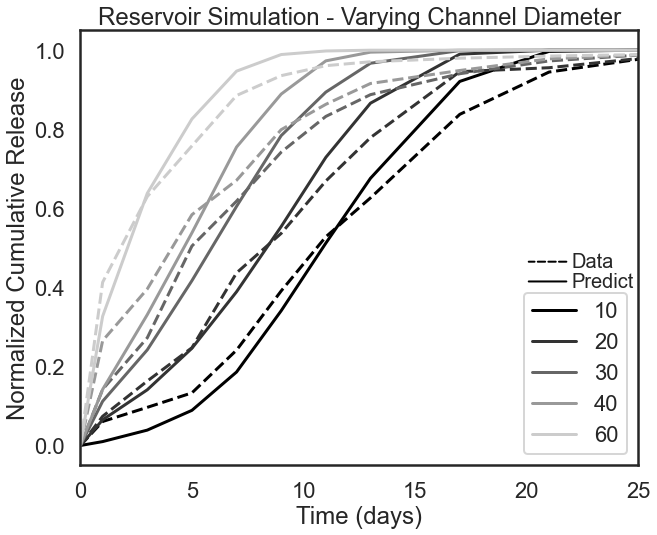

In [190]:
%matplotlib inline

n_ab = 1000
Size = 90    
s = 4;
L = 9;      
ST = 9; 
diameter = [10, 20, 30, 40, 60]
Diff = .0015
Surf = 0.53

sb.set_style('white')
sb.set_context("poster")
rcParams['figure.figsize'] = 10,8

for i in range(len(diameter)):
    Data, Time_points = experimental_data(diameter[i])
    plt.plot(Time_points, Data, '--k', c='{}'.format(i/len(diameter)))
    Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter[i], s, L, ST, Diff, Surf)
    plt.plot(Time_points,Cum_release, 'r',label='{}'.format(diameter[i]), c='{}'.format(i/len(diameter)))
 
plt.xlabel('Time (days)')
plt.ylabel('Normalized Cumulative Release')
plt.xlim(left=0,right=25)
plt.title('Reservoir Simulation - Varying Channel Diameter')
plt.annotate('Data', xy = (20, 0.465), xytext=(22,0.465), size=20,
            arrowprops={'arrowstyle':'-','ls':'dashed', 'color':'black'}, va='center')
plt.annotate('Predict', xy = (20, 0.415), xytext=(22,0.415), size=20,
            arrowprops={'arrowstyle':'-', 'color':'black'}, va='center')
plt.legend()
#plt.savefig('Reservoir-Plots/DiameterFit.jpg')

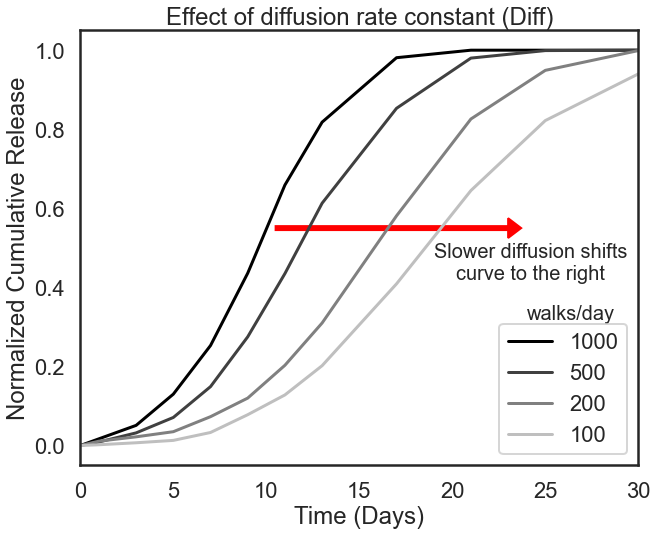

In [172]:
# Effect of Diff
Diff = [1/1000, 1/500, 1/200, 1/100]
Label = [round(1/diff) for diff in Diff]
Surf = 0.53
diameter = 10

for idx, diff in enumerate(Diff):
    Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter, s, L, ST, diff, Surf)
    plt.plot(Time_points,Cum_release, label='{}'.format(Label[idx]), c ='{}'.format(idx/len(Diff)))
plt.xlim(0, 30)
plt.legend(loc='lower right')
plt.title('Effect of diffusion rate constant (Diff)')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Cumulative Release')

plt.annotate('Slower diffusion shifts\n    curve to the right', xy = (15, 0.6), xytext=(19,0.42), size=20)
plt.annotate('walks/day', xy=(0,0), xytext=(24,0.32), size=20)
plt.arrow(10.5, 0.55, 12.5, 0, width=0.01, head_width=0.05, head_length=0.7, color='red')

Text(24.5, 0.3, 'mm/day')

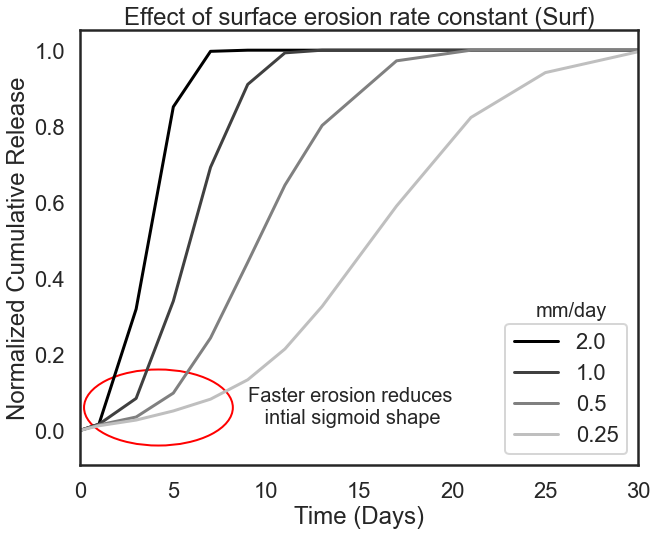

In [174]:
# Effect of Surf
Diff = .0015
Surf = [20/(90*2), 20/(90*1), 20/(90*0.5), 20/(90*0.25)]
Label = [round(20/(90*surf),2) for surf in Surf]
diameter = 10

fig, ax = plt.subplots()
for idx, surf in enumerate(Surf):
    Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter, s, L, ST, Diff, surf)
    ax.plot(Time_points,Cum_release, label='{}'.format(Label[idx]), c ='{}'.format(idx/len(Surf)))
ax.set_xlim(left=0, right=30)
ax.legend(loc='lower right')
ax.set_title('Effect of surface erosion rate constant (Surf)')
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Normalized Cumulative Release')

from matplotlib.patches import Ellipse
ellipse = Ellipse((4.2, 0.06), 8, 0.2, ec='red', fc='white')
ax.add_patch(ellipse)
ax.annotate('Faster erosion reduces\n   intial sigmoid shape', xy = (8, 0.02), xytext=(9,0.02), size=20)
ax.annotate('mm/day', xy=(0,0), xytext=(24.5,0.3), size=20)

Text(25, 0.45, 'mm')

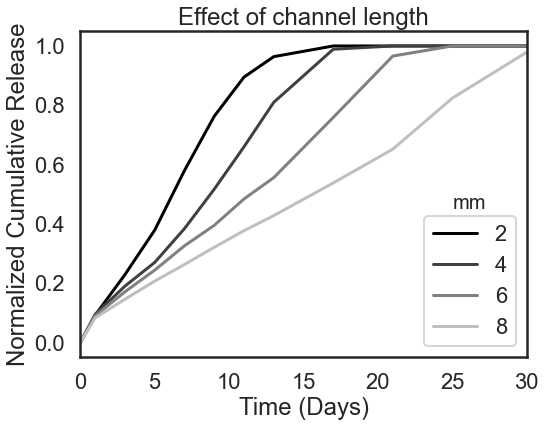

In [180]:
%matplotlib inline
# Effect of channel length
n_ab = 1000
Diff = .0015
Surf = 0.53
diameter = 30
Length = [9, 18, 27, 35]
Label = ['2', '4', '6', '8']
fig = plt.figure(figsize=(8,6))

for idx, L in enumerate(Length):
    Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter, s, L, ST, Diff, Surf)
    plt.plot(Time_points,Cum_release, label='{}'.format(Label[idx]), c ='{}'.format(idx/len(Length)))
plt.xlim(0, 30)
plt.legend(loc='lower right')
plt.title('Effect of channel length')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Cumulative Release')
plt.annotate('mm', xy=(0,0), xytext=(25,0.45), size=20)
#plt.annotate('Increasing length extends\ninital part of curve', xy = (8, 0.1), xytext=(10,0.1), size=20)
#plt.arrow(0, 0.1, 0.35, 0.2, width=0.007, head_width=0.03, head_length=0.03, color='red', transform=fig.transFigure)

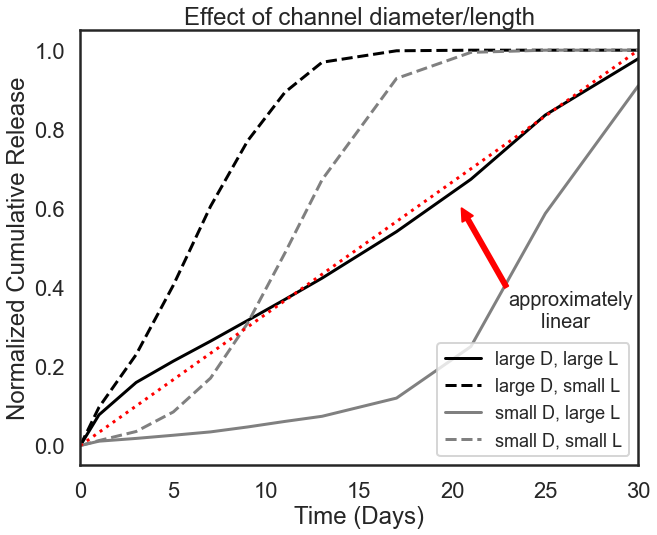

In [67]:
n_ab = 2000
Diff = .0015
Surf = 0.53

diameter = 30
L = 35
Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter, s, L, ST, Diff, Surf)
plt.plot(Time_points,Cum_release, label='large D, large L', c ='black')

diameter = 30
L = 9
Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter, s, L, ST, Diff, Surf)
plt.plot(Time_points,Cum_release, label='large D, small L', c ='black', ls='--')

diameter = 10
L = 35
Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter, s, L, ST, Diff, Surf)
plt.plot(Time_points,Cum_release, label='small D, large L', c ='gray')

diameter = 10
L = 9
Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter, s, L, ST, Diff, Surf)
plt.plot(Time_points,Cum_release, label='small D, small L', c ='gray', ls='--')

x = np.linspace(0,30)
y = x/30
plt.plot(x, y, ls=':', c='red')

plt.annotate('approximately\n      linear', xy = (20.5, 0.6), xytext=(23,0.3), size=20,
            arrowprops={'color':'red'})

plt.xlim(0, 30)
plt.legend(loc='lower right', fontsize=18)
plt.title('Effect of channel diameter/length')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Cumulative Release')
plt.savefig('Reservoir-Plots/LinearRelease.jpg')

Interestingly, a large diameter and large length results in an approximately linear cumulative release.  This could be ideal for treating an infection, which requires a sustained release of antibiotics for multiple weeks.

To visualize the drug release from the reservoirs, I reduced the reservoir to two dimensions by summing the number of antibiotics in the z-direction at every x,y coordinate to get the 'density' of antibiotics.  I calculated the density after each random walk and then animated the result to get a gif video of the antibiotic density changing over the course of elution.  The following code is the same as test_one_diameter, except with the addition of the 'Location' variable which tracks the location of the antibiotics in the reservoir over time.

In [212]:
def Visualize_Drug_Density(n_ab, Size, d, s, L, ST, Diff, Surf):
    
    # initialize Reservoir
    Reservoir = init_Reservoir(Size,d,L,ST,s)

    # create array with 5 columns for x,y,z coordinate in Reservoir, cumulative number of steps traveled, and
    # whether or not the antibiotic has eluted (0 is no, and 1 is yes)
    Ab = np.zeros([n_ab,5],dtype=int)

    # initialize x,y,z coordinates and make sure these coordinates are in carrier (value 0 or 3) and not shell (value 1)
    Ab[:,0:2] = np.random.randint(0,Size+2*ST,size = [n_ab,2])
    Ab[:,2] = np.random.randint(0,Size+2,size = n_ab)
    Ab = in_carrier(Ab,Reservoir,Size,ST)

    # Establish time points, experimental cumulative release, and predicted cumulative release vectors
    Data, Time_points = experimental_data(d)
    Cum_release = np.zeros(len(Time_points))
    
    # Establish flag variable that increases by 1 after each time point is reached
    flag = 1
    T_pt = Time_points[flag]

    # Initialize time and the number of steps traveled 
    step = 0
    Time = 0
    Location = np.zeros([Size+2*ST,Size+2*ST,25000])

    # random walk for antibiotics until all have eluted
    while np.sum(Ab[:,4]) < n_ab:
        if step % 5000 == 0:
            print(step, np.sum(Ab[:,4]))
        # determine the densities of antibiotics in z-direction
        for i in range(len(Ab)):
            if Ab[i,4]==0:
                Location[Ab[i,0], Ab[i,1], step] += 1
        
        Ab = move_once(Ab,Reservoir)
        
        # Update time based on Diff
        dt = Diff
        Time += dt
        
        # Reservoir experiences surface erosion at constant intervals determined by Surf (surface erosion rate constant)
        if (Time//Surf) != ((Time-dt)//Surf):
            Reservoir = Surf_degrade(Reservoir)
            
        # Record cumulative release at specified time points
        if (Time//T_pt) != ((Time-dt)//T_pt):
            if flag < len(Time_points):
                Cum_release[flag] = np.sum(Ab[:,4]/n_ab) 
                flag += 1
            if flag < len(Time_points):
                T_pt = Time_points[flag]            
        step += 1
    
    print(step)
    # For time points past the max time of while loop, update the cumulative release of those time points as 100%
    b = np.array(Time) < np.array(Time_points)
    Cum_release = b*1 + Cum_release
    
    # calculate performance
    P = 0.5*np.sum(np.square(Data - Cum_release))
    
    return Time_points, Cum_release, Data, P, Location

In [219]:
Size = 90   
s = 4;     
L = 35;     
ST = 9;      
Diff = .0015
Surf = 0.53
diameter = 30
n_ab = 100000

Time_points, Cum_release, Data, P, Location = Visualize_Drug_Density(n_ab, Size, diameter, s, L, ST, Diff, Surf)

0 0
5000 28078
10000 48369
15000 73536
20000 98079
24993


In [220]:
Location = Location[:,:,:24993]

I pooled adjacent entries of the Location matrix to convert the dimensions from 90x90 to 30x30 to see if this would enhance the animation of drug release.

In [221]:
import skimage.measure
Location_pooled = np.zeros([36,36,24993])
for i in range(24993):
    Location_pooled[:,:,i] = skimage.measure.block_reduce(Location[:,:,i], (3,3), np.sum)
np.shape(Location_pooled)

(36, 36, 24993)

In [222]:
np.max(Location_pooled)

170.0

MovieWriter ffmpeg unavailable; using Pillow instead.


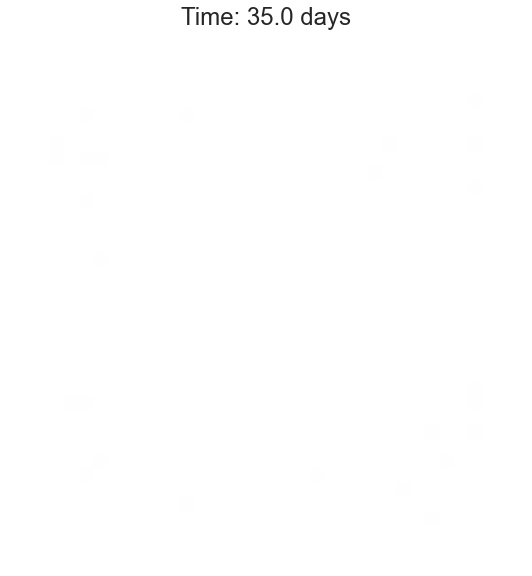

In [234]:
import matplotlib.animation as animation

frames = []
fig, ax = plt.subplots()
fig.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=None, hspace=None)
plt.axis('off')
for i in range(23483//80):
    label = ax.text(0.5,1.05,'Time: {} days'.format(round(i*80*Diff, 1)), size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)
    frames.append([ax.imshow(Location_pooled[:,:,i*80], cmap=plt.get_cmap('Greys', 171), vmin=0, vmax=170), label])

im_ani = animation.ArtistAnimation(fig, frames, interval=5, blit=True)
im_ani.save('Antibiotic_Density.gif', fps=25)

The resulting videos are attached in the Github repository.<br>
Overall, this project demonstrated the ability to accurately simulate drug release from simple reservoir shapes containing four channels with varying length and diameter.  Without having to test countless reservoir shapes, I was able to determine a shape that resulted in an approximately linear cumulative release, which is optimal for treating an infection.  The model also demonstrated the effect of changing the diffusion and surface erosion.  You can select drugs with varying molecular weight that will have different diffusive properties.  You can also select biodegradable carriers with different degradation properties to fine tune the drug release from reservoirs (in addition to tuning reservoir geometry). 

In [122]:
def Visualize_Random_Walk(n_ab, Size, d, s, L, ST, Diff, Surf):
    
    # initialize Reservoir
    Reservoir = init_Reservoir(Size,d,L,ST,s)

    # create array with 5 columns for x,y,z coordinate in Reservoir, cumulative number of steps traveled, and
    # whether or not the antibiotic has eluted (0 is no, and 1 is yes)
    Ab = np.zeros([n_ab,5],dtype=int)

    # initialize x,y,z coordinates and make sure these coordinates are in carrier (value 0 or 3) and not shell (value 1)
    Ab[:,0:2] = np.random.randint(0,Size+2*ST,size = [n_ab,2])
    Ab[:,2] = np.random.randint(0,Size+2,size = n_ab)
    Ab = in_carrier(Ab,Reservoir,Size,ST)

    # Establish time points, experimental cumulative release, and predicted cumulative release vectors
    Data, Time_points = experimental_data(d)
    Cum_release = np.zeros(len(Time_points))
    
    # Establish flag variable that increases by 1 after each time point is reached
    flag = 1
    T_pt = Time_points[flag]

    # Initialize time and the number of steps traveled 
    step = 0
    Time = 0
    Walk = np.zeros([n_ab,3,6200])
    Last_Walk = np.zeros(n_ab)

    # random walk for antibiotics until all have eluted
    while np.sum(Ab[:,4]) < n_ab:
        
        # determine the densities of antibiotics in z-direction
        for i in range(len(Ab)):
            if Ab[i,4]==0:
                Walk[i,:, step] = Ab[i,0:3]
            if Ab[i,4]==1 and Last_Walk[i]==0:
                Last_Walk[i] = step
        
        Ab = move_once(Ab,Reservoir)
        
        # Update time based on Diff
        dt = Diff
        Time += dt
        
        # Reservoir experiences surface erosion at constant intervals determined by Surf (surface erosion rate constant)
        if (Time//Surf) != ((Time-dt)//Surf):
            Reservoir = Surf_degrade(Reservoir)
            
        # Record cumulative release at specified time points
        if (Time//T_pt) != ((Time-dt)//T_pt):
            if flag < len(Time_points):
                Cum_release[flag] = np.sum(Ab[:,4]/n_ab) 
                flag += 1
            if flag < len(Time_points):
                T_pt = Time_points[flag]            
        step += 1
    
    print(step)
    # For time points past the max time of while loop, update the cumulative release of those time points as 100%
    b = np.array(Time) < np.array(Time_points)
    Cum_release = b*1 + Cum_release
    
    # calculate performance
    P = 0.5*np.sum(np.square(Data - Cum_release))
    
    return Walk, Last_Walk

Size = 90   
s = 4;     
L = 35;     
ST = 9;      
Diff = .0015
Surf = 0.53
diameter = 30
n_ab = 10

Walk, Last_Walk = Visualize_Random_Walk(n_ab, Size, d, s, L, ST, Diff, Surf)

5288


Text(0.5, 1.0, 'Side View')

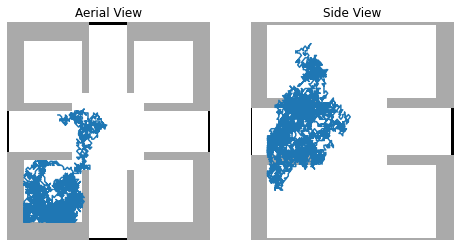

In [130]:
%matplotlib inline
fig, axs = plt.subplots(1,2, figsize=(8,4))
ax1, ax2 = axs[0], axs[1]

ab = 6
ax1.plot(Walk[ab,0,:int(Last_Walk[ab])], Walk[ab,1,:int(Last_Walk[ab])])
ax2.plot(Walk[ab,0,:int(Last_Walk[ab])], Walk[ab,2,:int(Last_Walk[ab])])

Reservoir = init_Reservoir(Size,d,L,ST,s)
Reservoir_slice1 = Reservoir[:,:,46]
Reservoir_slice2 = np.transpose(Reservoir[:,54,:])
colors = plt.get_cmap('binary',4)
ax1.pcolormesh(Reservoir_slice1, cmap=colors, vmin=0, vmax=3)
ax2.pcolormesh(Reservoir_slice2, cmap=colors, vmin=0, vmax=3)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Aerial View')
ax2.set_title('Side View')